In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from skimage.util.montage import montage2d
from skimage.io import imread

import tensorflow as tf
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from datetime import date

today_date = str(date.today())
# config = tf.ConfigProto() 
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# K.set_session(tf.Session(config=config))

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
xray_df = pd.read_csv('../input/sample_labels.csv')
xray_df.sample(4)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3395,00016750_000.png,No Finding,0,16750,031Y,F,PA,2992,2991,0.143,0.143
4477,00022310_006.png,Pleural_Thickening|Pneumonia,6,22310,075Y,F,AP,3056,2544,0.139,0.139
1941,00010104_005.png,No Finding,5,10104,064Y,M,PA,2992,2991,0.143,0.143
2759,00013829_009.png,No Finding,9,13829,036Y,M,PA,2992,2991,0.143,0.143


In [3]:
xray_df.count()

Image Index                    5606
Finding Labels                 5606
Follow-up #                    5606
Patient ID                     5606
Patient Age                    5606
Patient Gender                 5606
View Position                  5606
OriginalImageWidth             5606
OriginalImageHeight            5606
OriginalImagePixelSpacing_x    5606
OriginalImagePixelSpacing_y    5606
dtype: int64

# Filter patient id

In [4]:
filter_id = xray_df['Patient ID'].value_counts().index[:5].tolist()
xray_df = xray_df[~xray_df['Patient ID'].isin(filter_id)]

In [5]:
TARGET = 'normal'
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'sample_data', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', xray_df.shape[0])
xray_df['path'] = xray_df['Image Index'].map(all_image_paths.get)
# xray_df['infiltration'] = xray_df['Finding Labels'].map(lambda x: 'Infiltration' in x)
xray_df['normal'] = xray_df['Finding Labels'].map(lambda x: 'No Finding' in x).astype(int)
xray_df['Patient Age'] = xray_df['Patient Age'].map(lambda x: int(x[:-1]))
xray_df.sample(3)

Scans found: 5606 , Total Headers 5560


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,normal
2358,00011959_005.png,Infiltration,5,11959,21,F,AP,2500,2048,0.168,0.168,../input/sample_data/00011959_005.png,0
945,00004911_033.png,Effusion,33,4911,48,F,PA,2992,2991,0.143,0.143,../input/sample_data/00004911_033.png,0
4449,00022141_024.png,Pneumothorax,24,22141,32,M,AP,3056,2544,0.139,0.139,../input/sample_data/00022141_024.png,0


# Proprocessing Label

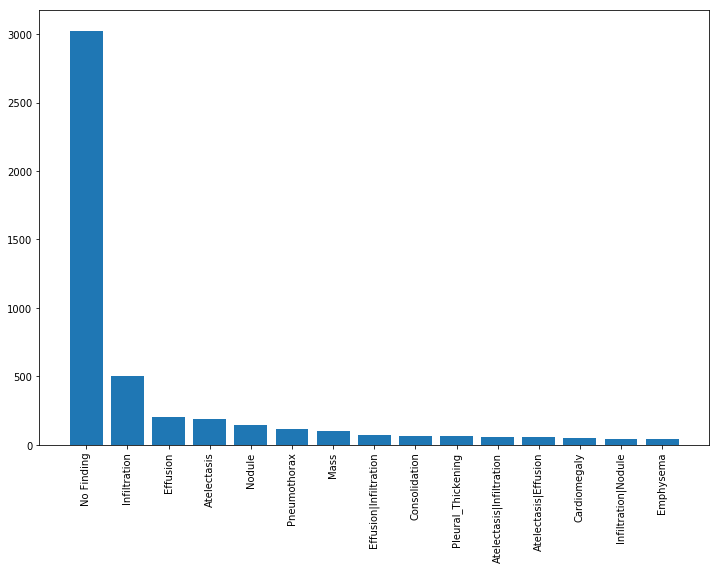

In [6]:
label_counts = xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [7]:
xray_df['Finding Labels'] = xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5544,00030229_000.png,,0,30229,40,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3526,00017417_000.png,Cardiomegaly,0,17417,53,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4329,00021307_024.png,Atelectasis|Mass,24,21307,43,F,PA,2730,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Clean Categories

In [8]:
# # keep at least 1000 cases
# MIN_CASES = 1000
# all_labels = [c_label for c_label in all_labels if xray_df[c_label].sum() > MIN_CASES]
# print('Clean Labels ({})'.format(len(all_labels)), 
#       [(c_label,int(xray_df[c_label].sum())) for c_label in all_labels])

In [9]:
#resample biases class

In [10]:
# sample_weights = xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
# sample_weights /= sample_weights.sum()
# xray_df = xray_df.sample(40000, weights=sample_weights)

# label_counts = xray_df['Finding Labels'].value_counts()[:15]
# fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
# ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
# ax1.set_xticks(np.arange(len(label_counts))+0.5)
# _ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [11]:
# label_counts = 100*np.mean(xray_df[all_labels].values,0)
# fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
# ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
# ax1.set_xticks(np.arange(len(label_counts))+0.5)
# ax1.set_xticklabels(all_labels, rotation = 90)
# ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
# _ = ax1.set_ylabel('Frequency (%)')

# Prepare training data

In [12]:
xray_df['disease_vec'] = xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

# Split data by patient id

In [13]:
import random
uniqueid = xray_df['Patient ID'].unique()
split = 0.8
percent = int(split * len(uniqueid))
percent
random.shuffle(uniqueid)
train_data = uniqueid[:percent]
valid_data = uniqueid[percent:]
print ('Unique train id : {0} | Unique test id {1}'.format(len(train_data), len(valid_data)))
xray_df['train'] = xray_df['Patient ID'].isin(train_data)
train_df = xray_df[xray_df['train'] == True]
valid_df = xray_df[xray_df['train'] == False]
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

Unique train id : 3380 | Unique test id 845
train 4393 validation 1167


In [14]:
# from sklearn.model_selection import train_test_split
# train_df, valid_df = train_test_split(xray_df, 
#                                    test_size = 0.25, 
#                                    random_state = 2018,
#                                    stratify = xray_df['Finding Labels'].map(lambda x: x[:4]))
# print('train', train_df.shape[0], 'validation', valid_df.shape[0])

# create data generator

In [15]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (299, 299)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [16]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    
    return df_gen

In [17]:
TRAIN_BATCH = 16
VAL_BATCH = 128
TEST_BATCH = 512

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 128) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 512)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4393 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1167 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1167 images


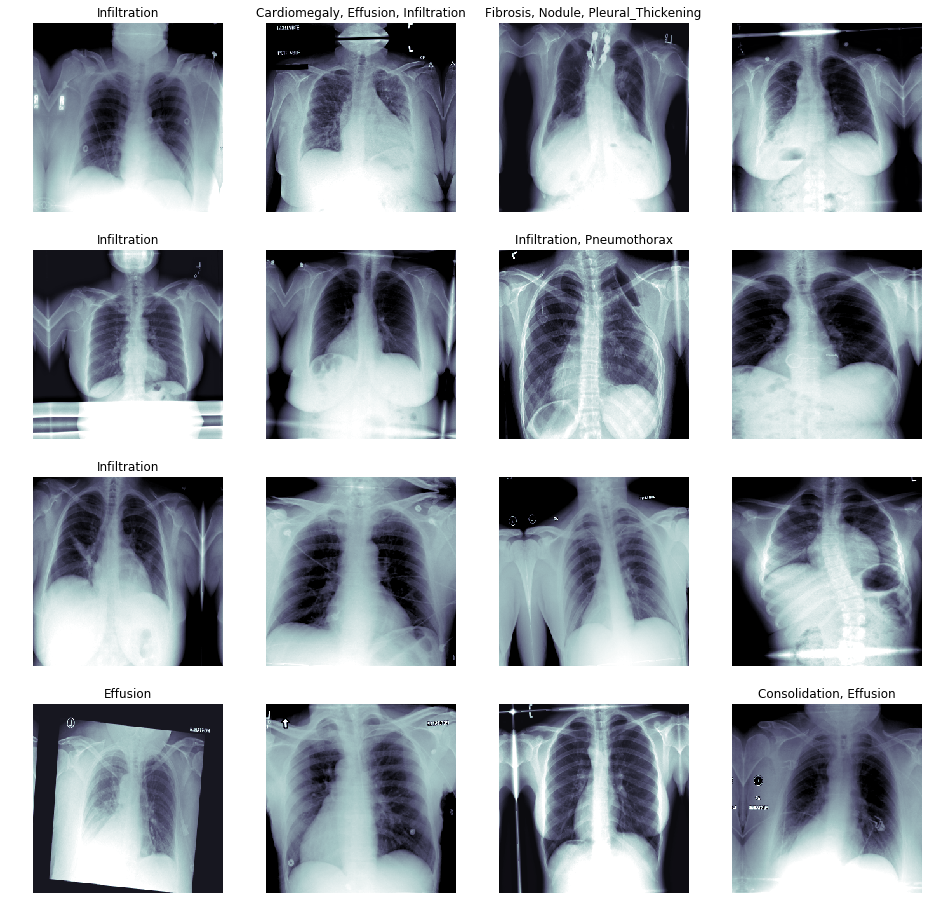

In [18]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Balance the distribution in the training set

# Pretrained Features

In [19]:
# ! pip install tqdm
from tensorflow.python.keras.applications import InceptionV3, Xception
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
from tqdm import tqdm
base_pretrained_model = Xception(input_shape =  t_x.shape[1:], include_top = False, weights = None)
# base_pretrained_model = InceptionV3(input_shape =  t_x.shape[1:], include_top = False)
multi_model = Sequential()
multi_model.add(base_pretrained_model)
multi_model.add(GlobalMaxPooling2D(name='globalMax'))
multi_model.add(Dropout(0.5, name='dropout1'))
multi_model.add(Dense(512, name='dense1'))
multi_model.add(Dropout(0.3, name='group2'))
multi_model.add(Dense(len(all_labels), activation = 'softmax', name='finalsoftmax'))
multi_model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy',
                           metrics = ['accuracy', 'mae'])
multi_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20860904  
_________________________________________________________________
globalMax (GlobalMaxPooling2 (None, 2048)              0         
_________________________________________________________________
dropout1 (Dropout)           (None, 2048)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               1049088   
_________________________________________________________________
group2 (Dropout)             (None, 512)               0         
_________________________________________________________________
finalsoftmax (Dense)         (None, 14)                7182      
Total params: 21,917,174
Trainable params: 21,862,646
Non-trainable params: 54,528
___________________________________________________________

In [20]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
weight_path="../weight_files/weights_best.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early]

In [21]:
# multi_model.load_weights(weight_path)

In [22]:
# K.clear_session()
# tf.reset_default_graph()

multi_model.fit_generator(train_gen, 
                          steps_per_epoch=280,
                          validation_data = (test_X, test_Y), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
279/280 [============================>.] - ETA: 1s - loss: 3.3686 - acc: 0.1503 - mean_absolute_error: 0.1079
Epoch 00001: val_loss improved from inf to 1.96842, saving model to ../weight_files/weights_best.hdf5
280/280 [==============================] - 415s 1s/step - loss: 3.3584 - acc: 0.1500 - mean_absolute_error: 0.1078 - val_loss: 1.9684 - val_acc: 0.0098 - val_mean_absolute_error: 0.1173
Epoch 2/10
279/280 [============================>.] - ETA: 1s - loss: 2.4635 - acc: 0.1603 - mean_absolute_error: 0.1074
Epoch 00002: val_loss improved from 1.96842 to 1.82918, saving model to ../weight_files/weights_best.hdf5
280/280 [==============================] - 387s 1s/step - loss: 2.4607 - acc: 0.1602 - mean_absolute_error: 0.1074 - val_loss: 1.8292 - val_acc: 0.0859 - val_mean_absolute_error: 0.1152
Epoch 3/10
279/280 [============================>.] - ETA: 1s - loss: 2.0009 - acc: 0.1691 - mean_absolute_error: 0.1077
Epoch 00003: val_loss improved from 1.82918 to 1.79758, s

In [23]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 9.57%
Cardiomegaly: 1.56%
Consolidation: 4.49%
Edema: 1.56%
Effusion: 11.91%
Emphysema: 3.91%
Fibrosis: 2.15%
Hernia: 0.00%
Infiltration: 18.75%
Mass: 4.49%
Nodule: 7.42%
Pleural_Thickening: 3.71%
Pneumonia: 1.37%
Pneumothorax: 4.30%


In [24]:
pred_Y = multi_model.predict(test_X, batch_size = 128, verbose = True)

512/512 [==============================] - 13s 25ms/step


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


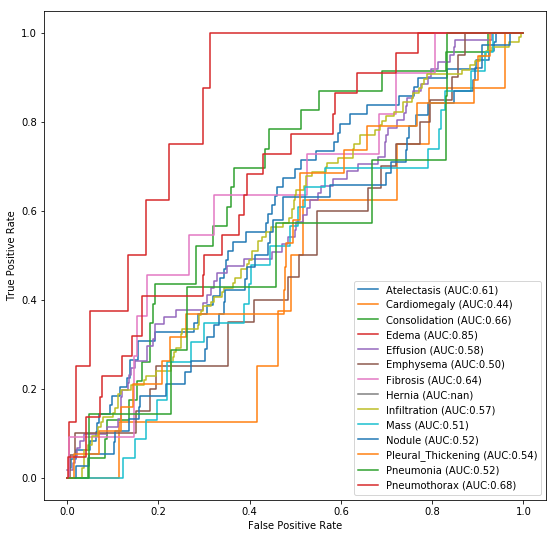

In [25]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [26]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 9.57%, PDx: 13.79%
Cardiomegaly: Dx: 1.56%, PDx: 2.66%
Consolidation: Dx: 4.49%, PDx: 4.97%
Edema: Dx: 1.56%, PDx: 2.07%
Effusion: Dx: 11.91%, PDx: 15.57%
Emphysema: Dx: 3.91%, PDx: 4.22%
Fibrosis: Dx: 2.15%, PDx: 2.49%
Hernia: Dx: 0.00%, PDx: 0.49%
Infiltration: Dx: 18.75%, PDx: 26.77%
Mass: Dx: 4.49%, PDx: 6.99%
Nodule: Dx: 7.42%, PDx: 8.02%
Pleural_Thickening: Dx: 3.71%, PDx: 3.77%
Pneumonia: Dx: 1.37%, PDx: 1.28%
Pneumothorax: Dx: 4.30%, PDx: 6.92%
